In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farahelshenawy","key":"492d5e388eaf79b6d55d8b6488387f52"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d feyzazkefe/trashnet


Dataset URL: https://www.kaggle.com/datasets/feyzazkefe/trashnet
License(s): unknown


In [ ]:
!unzip trashnet.zip -d trashnet_data


In [ ]:
import os

base_path = "trashnet_data"
for root, dirs, files in os.walk(base_path):
    print(root, "->", len(dirs), "dirs,", len(files), "files")


trashnet_data -> 1 dirs, 0 files
trashnet_data/dataset-resized -> 6 dirs, 0 files
trashnet_data/dataset-resized/metal -> 0 dirs, 410 files
trashnet_data/dataset-resized/glass -> 0 dirs, 501 files
trashnet_data/dataset-resized/cardboard -> 0 dirs, 403 files
trashnet_data/dataset-resized/plastic -> 0 dirs, 482 files
trashnet_data/dataset-resized/trash -> 0 dirs, 137 files
trashnet_data/dataset-resized/paper -> 0 dirs, 594 files


In [ ]:
! pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Dense, Resizing, Input
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import seaborn as sns
import os

import splitfolders

In [ ]:
# Define constants
BATCH_SIZE = 16
EPOCHS = 50
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 4.3e-05
FINE_TUNE_LR = 4e-06
NUM_CLASSES = 6
IMG_HEIGHT, IMG_WIDTH = 224, 224
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
DATA_DIR = 'trashnet_data/dataset-resized'
BATCH_SIZE = 16

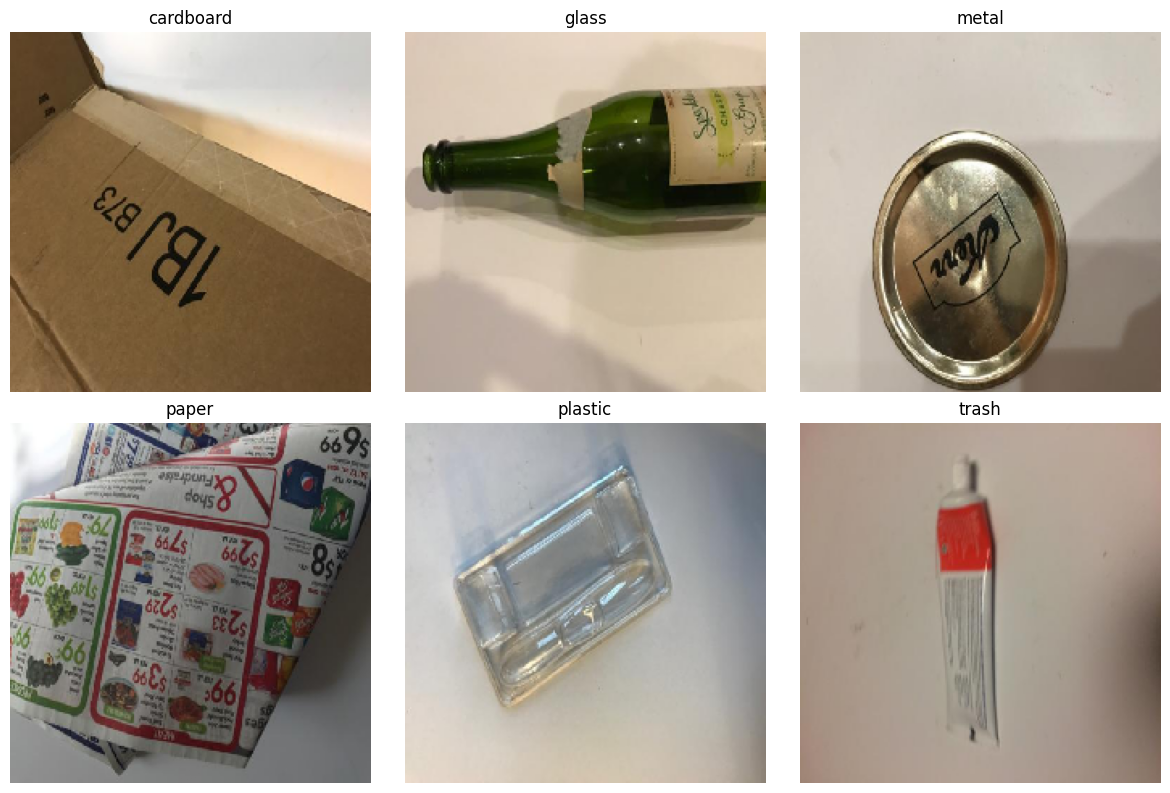

In [ ]:
# Load one image per class
images = []
class_names = []

for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    img_name = os.listdir(class_dir)[0]  # Pick first image
    img_path = os.path.join(class_dir, img_name)
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0  # Normalize
    images.append(img_array)
    class_names.append(class_name)

# Display images
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
input_folder= 'trashnet_data/dataset-resized'
output_folder='trashnet_data/split'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 2527 files [00:00, 7257.62 files/s]


In [ ]:
for root, dirs, files in os.walk(base_path):
    print(root, "->", len(dirs), "dirs,", len(files), "files")

trashnet_data -> 2 dirs, 0 files
trashnet_data/split -> 2 dirs, 0 files
trashnet_data/split/val -> 6 dirs, 0 files
trashnet_data/split/val/metal -> 0 dirs, 82 files
trashnet_data/split/val/glass -> 0 dirs, 101 files
trashnet_data/split/val/cardboard -> 0 dirs, 81 files
trashnet_data/split/val/plastic -> 0 dirs, 97 files
trashnet_data/split/val/trash -> 0 dirs, 28 files
trashnet_data/split/val/paper -> 0 dirs, 119 files
trashnet_data/split/train -> 6 dirs, 0 files
trashnet_data/split/train/metal -> 0 dirs, 328 files
trashnet_data/split/train/glass -> 0 dirs, 400 files
trashnet_data/split/train/cardboard -> 0 dirs, 322 files
trashnet_data/split/train/plastic -> 0 dirs, 385 files
trashnet_data/split/train/trash -> 0 dirs, 109 files
trashnet_data/split/train/paper -> 0 dirs, 475 files
trashnet_data/dataset-resized -> 6 dirs, 0 files
trashnet_data/dataset-resized/metal -> 0 dirs, 410 files
trashnet_data/dataset-resized/glass -> 0 dirs, 501 files
trashnet_data/dataset-resized/cardboard -> 0 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'trashnet_data/split/train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    'trashnet_data/split/val',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False
)

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [ ]:
# Handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.045031055900621), 1: np.float64(0.84125), 2: np.float64(1.0259146341463414), 3: np.float64(0.708421052631579), 4: np.float64(0.874025974025974), 5: np.float64(3.0871559633027523)}


In [ ]:
# Step 4: Build MobileNet transfer learning model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,756,742 (14.33 MB)

 Trainable params: 527,878 (2.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
steps_per_epoch = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps}")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_steps,
    #class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-6)
    ]
)


Steps per epoch: 126, Validation steps: 31
Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.3491 - loss: 1.7544 - val_accuracy: 0.6956 - val_loss: 0.8731 - learning_rate: 1.0000e-04
Epoch 2/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5000 - loss: 1.4197

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 1.4197 - val_accuracy: 0.6895 - val_loss: 0.8673 - learning_rate: 1.0000e-04
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - accuracy: 0.6287 - loss: 0.9734 - val_accuracy: 0.7540 - val_loss: 0.7185 - learning_rate: 1.0000e-04
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 1.1686 - val_accuracy: 0.7560 - val_loss: 0.7189 - learning_rate: 1.0000e-04
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.6797 - loss: 0.8235 - val_accuracy: 0.7661 - val_loss: 0.6838 - learning_rate: 1.0000e-04
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6875 - loss: 0.6984 - val_accuracy: 0.7681 - val_loss: 0.6833 - learning_rate: 1.0000e-04
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 307ms/step - accuracy: 0.7349 - loss: 0.7498 - val_accuracy: 0.7964 - val_loss: 0.5791 - learning_rate: 1.0000e-04
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0

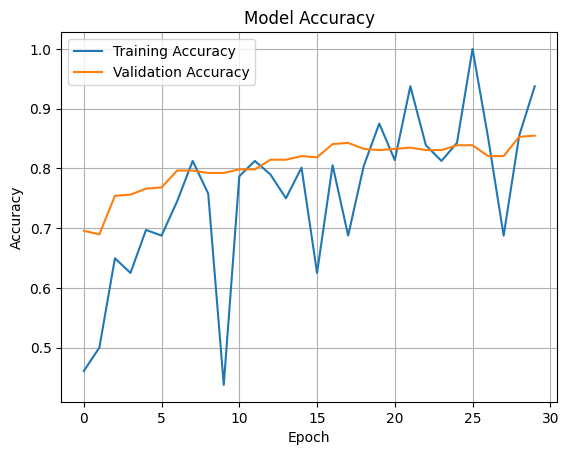

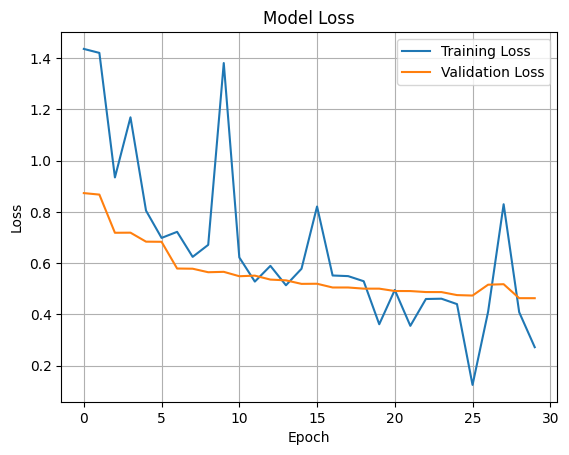

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


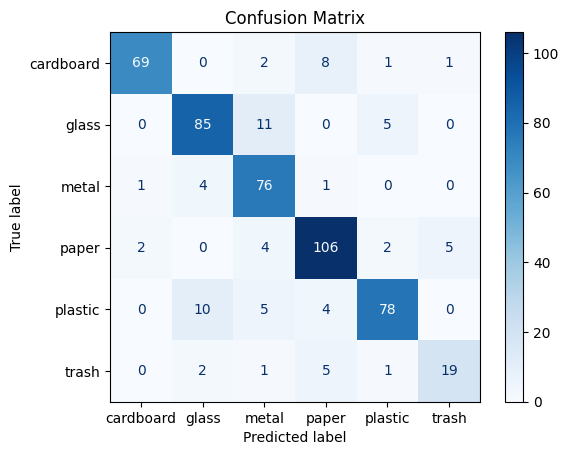

In [ ]:
import numpy as np

Y_pred = model.predict(val_generator, steps=val_steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes[:len(y_pred)]

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get the class labels as strings
class_labels = list(val_generator.class_indices.keys())

# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

   cardboard       0.96      0.85      0.90        81
       glass       0.84      0.84      0.84       101
       metal       0.77      0.93      0.84        82
       paper       0.85      0.89      0.87       119
     plastic       0.90      0.80      0.85        97
       trash       0.76      0.68      0.72        28

    accuracy                           0.85       508
   macro avg       0.85      0.83      0.84       508
weighted avg       0.86      0.85      0.85       508



In [ ]:
model.save('my_model.h5')
